In [356]:
import locale
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as splt

from pmdarima.arima import auto_arima
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [357]:
locale.setlocale(locale.LC_ALL, '')
warnings.filterwarnings("ignore")

In [358]:
def dist_ts(ts, lab = '', bins = 40):
    import scipy.stats as ss
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    ts.hist(ax = ax1, bins = bins, alpha = 0.5)
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Histogram of ' + lab)
    ss.probplot(ts, plot = ax2)

In [359]:
def lu_decompose(mat):
	lu_mat = np.matrix(np.zeros([mat.shape[0],mat.shape[1]]))
	n = mat.shape[0]
	for k in range(n):
		for j in range(k, mat.shape[1]):
			lu_mat[k, j] = mat[k, j] - lu_mat[k, :k] * lu_mat[:k, j]
		for i in range(k+1, n):
			lu_mat[i,k] = (mat[i,k] - lu_mat[i, :k] * lu_mat[:k, k]) / lu_mat[k, k]
	return np.matrix(lu_mat)

def solve_LU(lu_mat, b):
	y = np.matrix(np.zeros([lu_mat.shape[0], 1]))
	for i in range(y.shape[0]):
		y[i, 0] = b[i] - lu_mat[i, :i] * y[:i]
	x = np.matrix(np.zeros([lu_mat.shape[0], 1]))
	for i in range(1, x.shape[0] + 1):
		x[-i, 0] = (y[-i] - lu_mat[-i, -i:] * x[-i:, 0] )/ lu_mat[-i, -i]
	return x


def find_a_vector(n, x, y):
    N = len(x)
    a = np.zeros([n,n])
    b = np.zeros(n)
    s=""
    for i in range(n):
        for j in range(n):
            tmp_x = 0.0
            tmp_y = 0.0
            for k in range(N):
                tmp_x += pow(x[k], i+j)
                tmp_y += y[k]*pow(x[k], i)
            a[i][j] = tmp_x
        b[i] = tmp_y
    A = np.transpose((solve_LU(lu_decompose(a), b)))
    s+="\nF(x) = {}".format(A[0,0])
    for i in range(1,n):
        if(A[0,i]>0):
            s+=" + {}x^{}".format(A[0,i], i)
        else:
            s+=" - {}x^{}".format(-A[0,i], i)
    print(s)
    return A


def get_value(A, x):
    N=A.shape[1]
    tmp=0
    for i in range(N):
        tmp+=A[0,i]*pow(x, i)
    return tmp


def RSS(X,Y,N):    
    x = list(X)
    y = list(Y)
    tmp = 0
    A = find_a_vector(N, x, y)
    for i in range(len(x)):
        tmp += pow(y[i]-get_value(A, x[i]),2)
    fig = plt.figure(figsize=(12, 10))
    plt.grid()
    plt.scatter(x, y)
    plt.plot(x, [get_value(A, xi) for xi in x], color="red")
    print("\n(y-F)^2 = {}".format(tmp))
    return A

Экспортируем данные из таблицы и изменим формат даты.

In [360]:
df = pd.read_excel('beards.xlsx')

In [361]:
df["date"] = pd.to_datetime(df["date"],format="%B %Y г.")
df.head()

,date,population
0,2011-01-01,473387.90
1,2011-04-01,452985.70
2,2011-07-01,473730.22
3,2011-10-01,487755.49
4,2012-01-01,495852.60


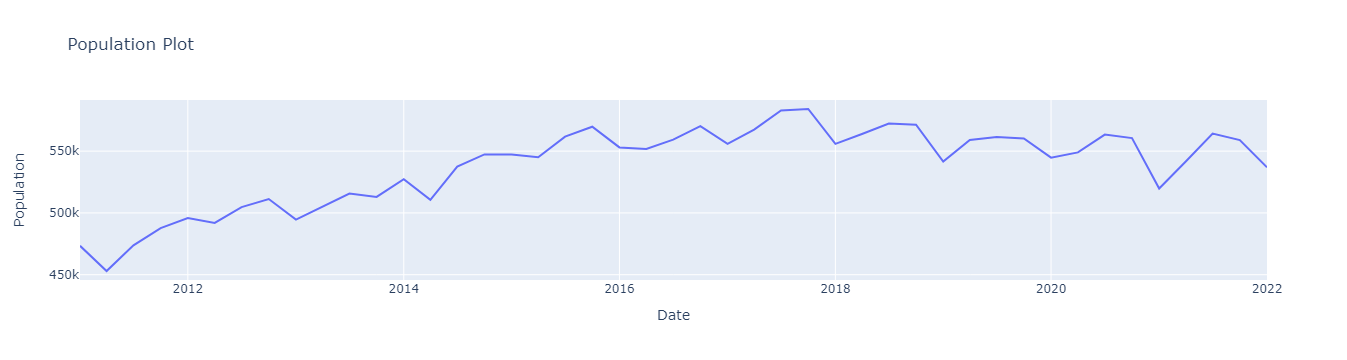

In [362]:
Population_info = go.Scatter(x=df.date, y=df.population)
layout = go.Layout(title='Population Plot', xaxis=dict(title='Date'), yaxis=dict(title='Population'))
fig = go.Figure(data=[Population_info],layout=layout)
fig.show()

Проверим не являются ли данные белым шумом 

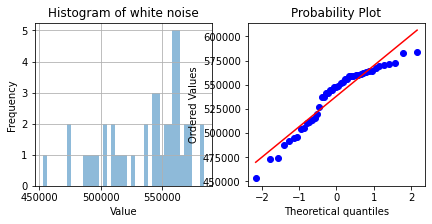

In [363]:
dist_ts(df.population, 'white noise')

Разделим данные на обучающие и тестовые.

In [364]:
border = df.shape[0] - int(df.shape[0]*0.25)
train, test = df[2:border], df[border:-2]

**Наивные прогнозы**

прогноз -- предидущее значение

p=1 RMSE:18648.829
p=2 RMSE:24768.569
p=3 RMSE:16369.531
p=4 RMSE:10699.259
p=5 RMSE:17703.061
p=6 RMSE:21755.756
p=7 RMSE:20596.897
p=8 RMSE:16159.462


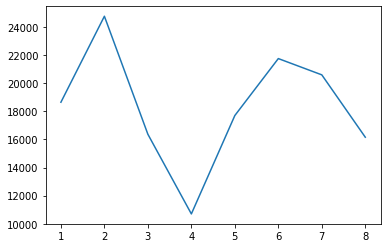

In [365]:
persistence_values = range(1, 9)
scores = list()
for p in persistence_values:
    history = [x for x in train['population']]
    predictions = list()
    for i in range(test.shape[0]):
        yhat = history[-p]
        predictions.append(yhat)
        history.append(test.iloc[i, 1])
    rmse = np.sqrt(mean_squared_error(test['population'], predictions))
    scores.append(rmse)
    print('p=%d RMSE:%.3f' % (p, rmse))
plt.plot(persistence_values, scores)
plt.show()

Лучший результат был достигнут при p=4. Это ожидаемый результат т.к. данные носят квартальный характер.

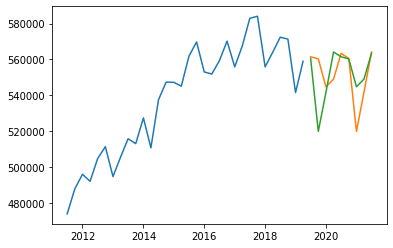

In [366]:
predictions = []
for i in range(len(test)):
    predictions.append(history[-4])
    history.append(test.iloc[i, 1])
plt.plot(train.date,train.population)
plt.plot(test.date, test.population)
plt.plot(test.date,predictions)
plt.show()

Прогноз на основе n-средних, или метод скользящего окна

w=1 RMSE:18648.829
w=2 RMSE:19983.344
w=3 RMSE:16929.147
w=4 RMSE:14393.964
w=5 RMSE:14631.574
w=6 RMSE:15579.481
w=7 RMSE:15645.924
w=8 RMSE:14912.962


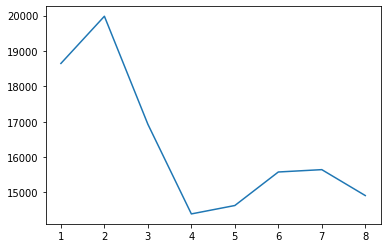

In [367]:
window_sizes = range(1, 9)
scores = list()
for w in window_sizes:
    history = [x for x in train['population']]
    predictions = list()
    for i in range(test.shape[0]):
        predictions.append(np.mean(history[-w:]))
        history.append(test.iloc[i, 1])
    rmse = np.sqrt(mean_squared_error(test['population'], predictions))
    scores.append(rmse)
    print('w=%d RMSE:%.3f' % (w, rmse))
plt.plot(window_sizes, scores)
plt.show()

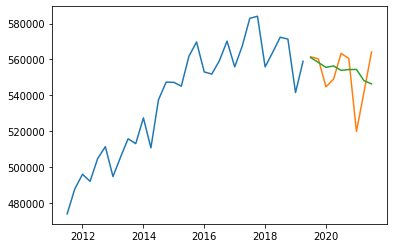

In [368]:
history = [x for x in train['population']]
predictions = list()
for i in range(test.shape[0]):
    predictions.append(np.mean(history[-4:]))
    history.append(test.iloc[i, 1])
plt.plot(train.date,train.population)
plt.plot(test.date, test.population)
plt.plot(test.date,predictions)
plt.show()

Попробуем постороить прогноз на больший срок и проверим распредиление остатков.

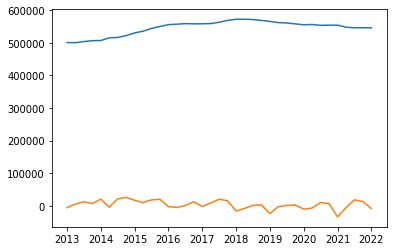

In [369]:
train_s, test_b = df[0:8], df[8:]
history = [x for x in train_s['population']]
predictions = list()
for i in range(test_b.shape[0]):
    predictions.append(np.mean(history[-4:]))
    history.append(test_b.iloc[i, 1])
rem = test_b.population - predictions
plt.plot(test_b.date,predictions)
plt.plot(test_b.date, rem)
plt.show()

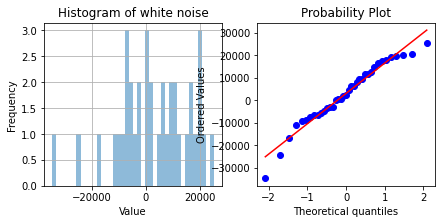

In [370]:
dist_ts(rem, 'white noise')

Очевидно, что мы немного приблизились к нормальному распредилению, но все еще довольно далеки от него, это значит, что в остатках еще есть довольно много не использованной информации.

(нужно ли добавить трансформации в этоу часть?)

**Экспоненциальное сглаживание**

Как мы уже выяснили раньше у рассматриваемго временного ряда присутсвует сезонность 4, поэтому начнем с модели без тренда, но с сезоностью.

In [371]:
exp_s = sm.tsa.statespace.ExponentialSmoothing(train.population, seasonal=4)
res_s = exp_s.fit()
print(res_s.summary())

                        Exponential Smoothing Results                         
Dep. Variable:             population   No. Observations:                   32
Model:                   ETS(A, N, A)   Log Likelihood                -342.001
Date:                 Пн, 18 апр 2022   AIC                            698.002
Time:                        21:15:40   BIC                            708.263
Sample:                             0   HQIC                           701.403
                                 - 32   Scale                    112357523.014
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.6560      0.185      3.538      0.000       0.293       1.019
smoothing_seasonal      0.3440      0.181      1.902      0.057      -0.010       0.698
initial_level   

In [372]:
predict_s = res_s.get_forecast(test.shape[0]).summary_frame()

fig = go.Figure()
fig.add_traces(go.Scatter(x=train.index, y=train.population, name='train'))
fig.add_traces(go.Scatter(x=test.index, y=test.population, name = 'test'))
fig.add_traces(go.Scatter(x=predict_s.index, y=predict_s['mean'], name = 'predict'))
fig.show()

rmse = np.sqrt(mean_squared_error(test['population'], predict_s['mean']))
print('RMSE:%.3f' % (rmse))

RMSE:11357.271


Попробуем добавить в модель тренд

In [373]:
exp_st = sm.tsa.statespace.ExponentialSmoothing(train.population, trend=True, damped_trend=True, seasonal=4)
res_st = exp_st.fit()
print(res_st.summary())

                        Exponential Smoothing Results                         
Dep. Variable:             population   No. Observations:                   32
Model:                  ETS(A, Ad, A)   Log Likelihood                -339.153
Date:                 Пн, 18 апр 2022   AIC                            698.306
Time:                        21:15:41   BIC                            712.964
Sample:                             0   HQIC                           703.165
                                 - 32   Scale                     94036763.772
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.5620      0.219      2.568      0.010       0.133       0.991
smoothing_trend         0.0001      0.145      0.001      0.999      -0.284       0.285
smoothing_season

In [374]:
predict_st = res_st.get_forecast(test.shape[0]).summary_frame()

fig = go.Figure()
fig.add_traces(go.Scatter(x=train.index, y=train.population, name='train'))
fig.add_traces(go.Scatter(x=test.index, y=test.population, name = 'test'))
fig.add_traces(go.Scatter(x=predict_st.index, y=predict_st['mean'], name = 'predict'))
fig.show()

rmse = np.sqrt(mean_squared_error(test['population'], predict_st['mean']))
print('RMSE:%.3f' % (rmse))


RMSE:15660.771


Очевидно, что модель с трендом работает хуже, попробуем применить мультиплекативный тренд.

In [375]:
exp_stm = sm.tsa.ExponentialSmoothing(train.population, trend='mul', damped=True, seasonal='add', seasonal_periods=4)
res_stm = exp_stm.fit()
print(res_stm.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               population   No. Observations:                   32
Model:             ExponentialSmoothing   SSE                     3401012770.066
Optimized:                         True   AIC                            609.411
Trend:                   Multiplicative   BIC                            622.603
Seasonal:                      Additive   AICC                           622.611
Seasonal Periods:                     4   Date:                  Пн, 18 апр 2022
Box-Cox:                          False   Time:                         21:15:41
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4646429                alpha                 True
smoothing_trend          

In [376]:
predict_stm = res_stm.forecast(test.shape[0])

fig = go.Figure()
fig.add_traces(go.Scatter(x=train.index, y=train.population, name='train'))
fig.add_traces(go.Scatter(x=test.index, y=test.population, name = 'test'))
fig.add_traces(go.Scatter(x=predict_stm.index, y=predict_stm, name = 'predict'))
fig.show()

rmse = np.sqrt(mean_squared_error(test['population'], predict_stm))
print('RMSE:%.3f' % (rmse))

RMSE:55398.022


Лучшая из рассмотренных моделий -- экспоненциальное сглаживание с сезоностью. Попробуем применить различные трансформации для улучшения резултата.

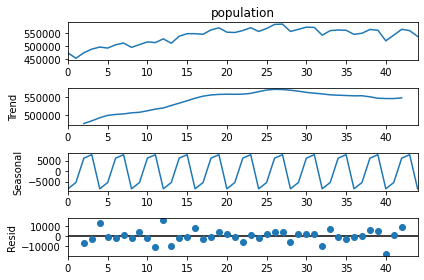

In [377]:
components = seasonal_decompose(df.population, model='additive', period=4)
components.plot()
plt.show()

Построим апроксимацию тренда методом МНК


F(x) = 374406.1875909593 + 18081.416327333733x^1 - 535.6980391932655x^2 + 4.799183844574789x^3

(y-F)^2 = 280606044.02630764


4

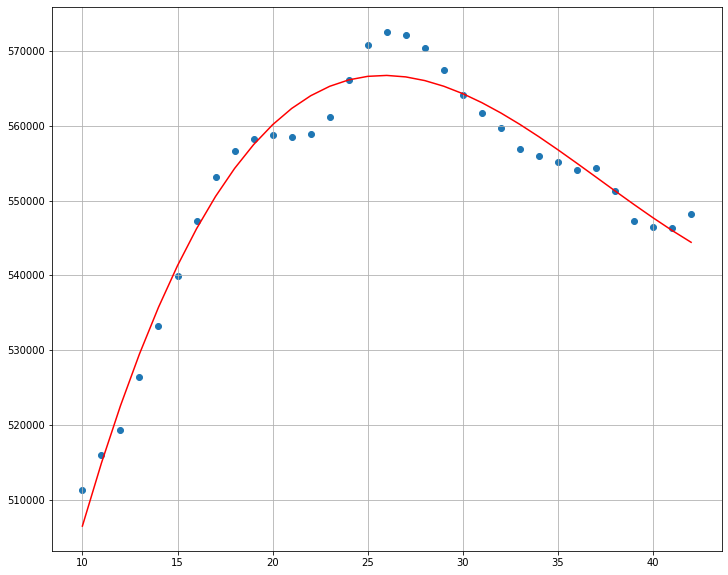

In [378]:
trend_evaluation = RSS(list(range(10,43)),list(components.trend[10:43]),4)
trend_evaluation.shape[1]

In [379]:
#season = components.seasonal+np.abs(np.min(components.seasonal))
train_se, test_se = components.seasonal[1:border], components.seasonal[border:]

exp_s_tbs = sm.tsa.statespace.ExponentialSmoothing(train_se, seasonal=4)
res_s_tbs = exp_s_tbs.fit()
print(res_s.summary())

                        Exponential Smoothing Results                         
Dep. Variable:             population   No. Observations:                   32
Model:                   ETS(A, N, A)   Log Likelihood                -342.001
Date:                 Пн, 18 апр 2022   AIC                            698.002
Time:                        21:15:42   BIC                            708.263
Sample:                             0   HQIC                           701.403
                                 - 32   Scale                    112357523.014
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.6560      0.185      3.538      0.000       0.293       1.019
smoothing_seasonal      0.3440      0.181      1.902      0.057      -0.010       0.698
initial_level   

In [380]:
predict_s_tbs = res_s_tbs.get_forecast(len(test_se)).summary_frame()['mean']

fig = go.Figure()
fig.add_traces(go.Scatter(x=train.index, y=train_se, name='train'))
fig.add_traces(go.Scatter(x=test.index, y=test_se, name = 'test'))
fig.add_traces(go.Scatter(x=predict_s_tbs.index, y=predict_s_tbs, name = 'predict'))
fig.show()

rmse = np.sqrt(mean_squared_error(test_se, predict_s_tbs))
print('RMSE:%.3f' % (rmse))

RMSE:0.000


In [381]:
train_se_r, test_se_r = components.resid[2:border], components.resid[border:-2]

model = SARIMAX(train_se_r, order=(1,1,1), seasonal_order=(1,1,1,4))
model_fit = model.fit()

In [382]:
predict_sarimax = model_fit.forecast(len(test_se_r))

fig = go.Figure()
fig.add_traces(go.Scatter(x=train.index, y=train_se_r, name='train'))
fig.add_traces(go.Scatter(x=test.index, y=test_se_r, name = 'test'))
fig.add_traces(go.Scatter(x=predict_s_tbs.index, y=predict_sarimax, name = 'predict'))
fig.show()

rmse = np.sqrt(mean_squared_error(test_se_r, predict_sarimax))
print('RMSE:%.3f' % (rmse))

RMSE:6218.804


In [383]:
auto = auto_arima(train_se_r,
                 trend='c',
                 d=None,
                 start_p=0,
                 start_q=0,
                 max_p=3,
                 max_d=2,
                 max_q=3, 
                 D=None, 
                 start_P=1,
                 start_Q=1, 
                 max_P=3,
                 max_D=2,
                 max_Q=3, 
                 m=4, 
                 max_order=None,
                 alpha=0.05,
                 seasonal=True,
                 stationary=False,
                 stepwise=True,
                 information_criterion='aic',
                 supress_warnings=True,
                 error_action='ignore',
                 trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=653.455, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=651.048, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=647.225, Time=0.02 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=651.048, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=646.526, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=647.722, Time=0.02 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=648.588, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=641.981, Time=0.02 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC=643.339, Time=0.03 sec
 ARIMA(2,0,0)(0,0,1)[4] intercept   : AIC=643.496, Time=0.04 sec
 ARIMA(2,0,0)(1,0,1)[4] intercept   : AIC=645.246, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[4] intercept   : AIC=640.851, Time=0.03 sec
 ARIMA(3,0,0)(1,0,0)[4] intercept   : AIC=638.817, Time=0.07 sec
 ARIMA(3,0,0)(2,0,0)[4] intercept   : AIC=640.469, 

In [384]:
predict_auto = model_fit.forecast(len(test_se_r))

fig = go.Figure()
fig.add_traces(go.Scatter(x=train.index, y=train_se_r, name='train'))
fig.add_traces(go.Scatter(x=test.index, y=test_se_r, name = 'test'))
fig.add_traces(go.Scatter(x=predict_s_tbs.index, y=predict_auto, name = 'predict'))
fig.show()

rmse = np.sqrt(mean_squared_error(test_se_r, predict_auto))
print('RMSE:%.3f' % (rmse))

RMSE:6218.804


Путем сложения прогнозов для каждой из компонент получим итоговый прогноз

In [385]:
full_predict = predict_s_tbs+predict_auto+[get_value(trend_evaluation, xi) for xi in range(border,border+len(predict_s_tbs))]

fig = go.Figure()
fig.add_traces(go.Scatter(x=train.index, y=train.population, name='train'))
fig.add_traces(go.Scatter(x=test.index, y=test.population, name = 'test'))
fig.add_traces(go.Scatter(x=predict_stm.index, y=full_predict, name = 'predict'))
fig.show()

rmse = np.sqrt(mean_squared_error(test.population, full_predict[:-2]))
print('RMSE:%.3f' % (rmse))

RMSE:7181.040


Градиентный бустинг.
Градиентный бустинг для корректной работы тредует набор от временного ряда наличия параметров. Добавим сезонную составляющую т.к. мы уже научились довольно хорошо прогнозировать трендовую составлющую, добавим ее и все что с ней связано в качестве 'фичи'. Так же добавим скользящее среднее и несколько лагов для 'объяснения' трендовой составляющей.

In [399]:
df['seasonal'] = components.seasonal
df['seasonal'] = df['seasonal'].astype(str)
tmp_population = df['population'].astype(str)
df['lag1'] = pd.Series(name='lag', data=tmp_population.shift(1), index=df.index)
df['lag2'] = pd.Series(name='lag', data=tmp_population.shift(2), index=df.index)
df['lag3'] = pd.Series(name='lag', data=tmp_population.shift(3), index=df.index)
df['lag4'] = pd.Series(name='lag', data=tmp_population.shift(4), index=df.index)
df['lag5'] = pd.Series(name='lag', data=tmp_population.shift(5), index=df.index)
df['lag6'] = pd.Series(name='lag', data=tmp_population.shift(6), index=df.index)

history = [x for x in df['population'][:4]]
predictions = list()
for i in range(df.shape[0]-4):
    predictions.append(str(np.mean(history[-4:])))
    history.append(df.iloc[i, 1])
df['smoothing'] =  pd.Series(name='sm', data=['fall']*4+predictions, index=df.index)

def get_season(month):
        if (month == 12 or month < 3):
            return 'WINTER'
        elif (month >= 3 and month < 6):
            return 'SPRING'
        elif (month >= 6 and month < 9):
            return 'SUMMER'
        elif (month >= 9 and month < 12):
            return 'AUTUMN'
        else:
            return 'FALL'

df['month']  = pd.DatetimeIndex(df['date']).month
df['season'] = df['month'].apply(
    lambda x: get_season(x))
df = df.fillna('FALL')
df.head()

,date,population,seasonal,lag1,lag2,lag3,lag4,lag5,lag6,month,season,smoothing
0,2011-01-01,473387.90,-8452.196644886364,FALL,FALL,FALL,FALL,FALL,FALL,1,WINTER,fall
1,2011-04-01,452985.70,-5470.417144886348,473387.9,FALL,FALL,FALL,FALL,FALL,4,SPRING,fall
2,2011-07-01,473730.22,6141.996934659076,452985.7,473387.9,FALL,FALL,FALL,FALL,7,SUMMER,fall
3,2011-10-01,487755.49,7780.616855113637,473730.22,452985.7,473387.9,FALL,FALL,FALL,10,AUTUMN,fall
4,2012-01-01,495852.60,-8452.196644886364,487755.49,473730.22,452985.7,473387.9,FALL,FALL,1,WINTER,471964.8275


In [400]:
x_train, x_test, y_train, y_test = df[:border].drop(['population'],1), df[border:].drop(['population'],1),df[:border]['population'], df[border:]['population']

In [401]:
ctbst = CatBoostRegressor( random_seed=42, logging_level='Silent')
ctbst.fit(x_train, y_train, cat_features=['seasonal','lag1','lag2','lag3','lag4','lag5','lag6','month','season','smoothing'], plot=False)
    
# получаем прогнозы CatBoost
ctbst_predictions = ctbst.predict(x_test)

In [402]:
fig = go.Figure()
fig.add_traces(go.Scatter(x=x_train.index, y=y_train, name='train'))
fig.add_traces(go.Scatter(x=x_test.index, y=y_test, name = 'test'))
fig.add_traces(go.Scatter(x=x_test.index, y=ctbst_predictions, name = 'predict'))
fig.show()

rmse = np.sqrt(mean_squared_error(y_test, ctbst_predictions))
print('RMSE:%.3f' % (rmse))

RMSE:15035.177
